In [10]:
import torch
import os
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader


In [2]:
torch.cuda.is_available()

False

In [3]:
def load_mnist(path, kind = 'train'):
    '''
    https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
    '''

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz' % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype = np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)

    return images, labels


In [5]:
x_train, y_train = load_mnist('./fashion_mnist_data/', kind = 'train')

x_test, y_test = load_mnist('./fashion_mnist_data/', kind = 't10k')


In [91]:
# combine loaded training and testing data and label into one df/

def data_label_to_cscv(data, label, csv_name):
    # concat pixel values and label to make one np.array
    data_label = np.concatenate((label.reshape(-1, 1), data), axis = 1)
    # convert to df
    data_label = pd.DataFrame(data_label, columns = ['label'] + ['pixel' + str(i + 1) for i in range(784)])

    # save to csv
    # data_label.to_csv(csv_name, index = False)
    
    return data_label


In [95]:
data_train = data_label_to_cscv(x_train, y_train, 'data_train.csv')
data_test = data_label_to_cscv(x_test, y_test, 'data_test.csv')


In [8]:
# load data
# data_train = pd.read_csv('data_train.csv')
# data_test = pd.read_csv('data_test.csv')


'''
class Dataset(object):
    """An abstract class representing a Dataset.
    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

'''

In [138]:
class my_dataset(Dataset):
    '''
    Dataset: An abstract class representing a Dataset.
    '''
    
    def __init__(self, data, transform = None):
        self.fashion_mnist = list(data.values)
        self.transform = transform
        label, img = [], []
        
        for one_line in self.fashion_mnist:
            label.append(one_line[0])
            img.append(one_line[1:])
            
        self.label = np.asarray(label)
        self.img = np.asarray(img).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, CHANNEL).astype('float')
        
    def __getitem__(self, item):
        label, img = self.label[item], self.img[item]
        if self.transform is not None:
            img = self.transform(img)
            
        return label, img
    
    def __len__(self):
        return len(self.label)
    

In [139]:
BATCH_SIZE = 1000
LR = 0.005
NUM_CLASS = 10
IMAGE_SIZE = 28
CHANNEL = 1
Train_epoch = 5
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CLASS_CLOTHING = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

In [164]:
# Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
my_transform = transforms.Compose([transforms.ToTensor()])

train_data = my_dataset(data_train, transform = my_transform)
test_data = my_dataset(data_test, transform = my_transform)

# Combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.
# make data iterable
train_dataloader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = False)


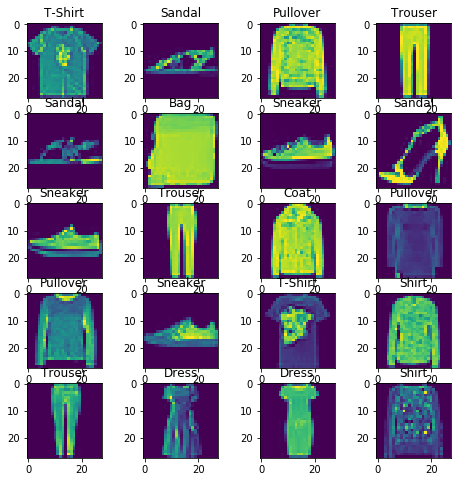

In [165]:
# visualize 20 random images in train_data

col = 4
row = 5
N = len(train_data.img)
fig = plt.figure(figsize = (8, 8))

for i in range(1, 21):
    img_index = np.random.randint(N)
    img = train_data.img[img_index][:, :, 0]
    img_title = CLASS_CLOTHING[train_data.label[img_index]]
    
    fig.add_subplot(row, col, i)
    plt.title(img_title)
    plt.imshow(img)
    

In [166]:
# define the model

class my_model(nn.Module):
    def __init__(self, num_of_class):
        super(my_model, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = 5, stride = 1, padding = 2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size = 5, stride = 1, padding = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(7 * 7 * 32, 120),
            nn.Dropout(p = 0.4),
            nn.Linear(120, num_of_class)
        )
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.layer3(out)
        
        return out

In [167]:
model = my_model(10)
print (model)


my_model(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=1568, out_features=120, bias=True)
    (1): Dropout(p=0.4)
    (2): Linear(in_features=120, out_features=10, bias=True)
  )
)


1568

In [151]:
def train():
    # model = my_model(NUM_CLASS).to(device)
    model = my_model(NUM_CLASS)
    optimizer = torch.optim.Adam(model.parameters(), lr = LR)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(1, Train_epoch + 1):
        for batch_id, (label, image) in enumerate(train_dataloader):
            # label, image = label.to(device), image.to(device)
            image = Variable(image.float())
            label = Variable(label.long())
            output = model(image)
            loss = criterion(output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if batch_id % 200 == 0:
                print('loss :{:.4f} Epoch[{}/{}]'.format(loss.item(), epoch, Train_epoch))
                
    return model

In [168]:
def test(model):
    with torch.no_grad():
        correct = 0
        total = 0
        for label, image in test_dataloader:
            # image = image.to(device)
            # label = label.to(device)
            image = Variable(image.float())
            label = Variable(label.long())
            outputs = model(image)
            predicted = torch.argmax(outputs, dim = 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            
        print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))
        

In [169]:
if __name__ == '__main__':
    model = train()
    test(model)
    

loss :2.3254 Epoch[1/5]
loss :0.4475 Epoch[2/5]
loss :0.3780 Epoch[3/5]
loss :0.2624 Epoch[4/5]
loss :0.3358 Epoch[5/5]
Test Accuracy of the model on the test images: 89.17 %
